In [1]:
#!pip install small-text
#!pip install datasets
#!pip install sentence-transformers
#!pip install setfit
#!pip install seaborn


In [2]:
import datasets
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd


In [3]:
train_df, test_df = pd.read_csv('seed.csv'), pd.read_csv('test.csv')

In [4]:
train_df

,example,label
0,I have withdrawn cash from ATM but i received ...,wrong_amount_of_cash_received
1,How man currencies can I hold?,fiat_currency_support
2,Can I unblock my pin?,pin_blocked
3,How do i get my salary in the account?,receiving_money
4,Can my daughter open an account?,age_limit
...,...,...
194,How long will it take for the transfer to reac...,transfer_timing
195,I didn't receive the right amount of cash back,wrong_amount_of_cash_received
196,I have paid by my card but payment is still it...,pending_card_payment
197,I made a payment but the app reverted the paym...,reverted_card_payment?


In [5]:
combine_df = pd.concat([train_df,test_df],axis=0)

In [6]:
categories = combine_df.label.unique()

In [7]:
label_to_id = { label : id for id, label in enumerate(categories)}
id_to_label = { id : label for id, label in enumerate(categories)}

In [8]:
target_labels = np.arange(len(categories))

In [9]:
import numpy as np
from small_text import TextDataset

In [10]:
train_df['label'] = train_df['label'].map(label_to_id)
test_df['label'] = test_df['label'].map(label_to_id)

In [11]:
train = TextDataset.from_arrays(train_df['example'].to_list(), np.array(train_df['label']), target_labels=target_labels)
test = TextDataset.from_arrays(test_df['example'].to_list(), np.array(test_df['label']), target_labels=target_labels)

/usr/local/lib/python3.10/dist-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


In [12]:
import numpy as np
from small_text import TextDataset

In [13]:
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory

In [14]:

num_classes = len(categories)

sentence_transformer_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name)
clf_factory = SetFitClassificationFactory(setfit_model_args,
                                          num_classes)

In [15]:
from small_text import (
    PoolBasedActiveLearner,
    random_initialization_balanced,
    BreakingTies,
    SubsamplingQueryStrategy
)

# define a query strategy and initialize a pool-based active learner
query_strategy = SubsamplingQueryStrategy(BreakingTies())
# suppress progress bars in jupyter notebook
setfit_train_kwargs = {'show_progress_bar': False}
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, fit_kwargs={'setfit_train_kwargs': setfit_train_kwargs})


# simulate a warm start
def initialize_active_learner(active_learner, y_train):

    x_indices_initial = random_initialization_balanced(y_train, n_samples=20)
    y_initial = y_train[x_indices_initial]

    active_learner.initialize_data(x_indices_initial, y_initial)

    return x_indices_initial


initial_indices = initialize_active_learner(active_learner, train.y)
labeled_indices = initial_indices

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 800
  Num epochs = 1
  Total optimization steps = 25
  Total train batch size = 32


In [16]:
import gc
import torch
from sklearn.metrics import accuracy_score


num_queries = 13

y_pred = []


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)

    test_acc = accuracy_score(y_pred_test, test.y)

    precision, recall, f1, _ = precision_recall_fscore_support(y_pred_test, test.y, average='macro',zero_division=1)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))

    return test_acc, y_pred_test, precision, recall


accuracy_list = []
precision_list = []
recall_list = []
label_list = []


for i in range(num_queries):
    q_indices = active_learner.query(num_samples=10)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[q_indices]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    # memory fix: https://github.com/UKPLab/sentence-transformers/issues/1793
    gc.collect()
    torch.cuda.empty_cache()

    labeled_indices = np.concatenate([q_indices, labeled_indices])

    print('---------------')
    print('Iteration #{:d} ({} samples)'.format(i, len(labeled_indices)))
    label_list.append(len(labeled_indices))

    test_acc, y_pred_test, precision, recall = evaluate(active_learner, train[labeled_indices], test)
    accuracy_list.append(test_acc)
    precision_list.append(precision)
    recall_list.append(recall)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1200
  Num epochs = 1
  Total optimization steps = 38
  Total train batch size = 32


---------------
Iteration #0 (30 samples)
Train accuracy: 1.00
Test accuracy: 0.19


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 50
  Total train batch size = 32


---------------
Iteration #1 (40 samples)
Train accuracy: 1.00
Test accuracy: 0.23


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2000
  Num epochs = 1
  Total optimization steps = 63
  Total train batch size = 32


---------------
Iteration #2 (50 samples)
Train accuracy: 1.00
Test accuracy: 0.26


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2400
  Num epochs = 1
  Total optimization steps = 75
  Total train batch size = 32


---------------
Iteration #3 (60 samples)
Train accuracy: 1.00
Test accuracy: 0.30


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 2800
  Num epochs = 1
  Total optimization steps = 88
  Total train batch size = 32


---------------
Iteration #4 (70 samples)
Train accuracy: 1.00
Test accuracy: 0.33


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3200
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 32


---------------
Iteration #5 (80 samples)
Train accuracy: 1.00
Test accuracy: 0.38


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3600
  Num epochs = 1
  Total optimization steps = 113
  Total train batch size = 32


---------------
Iteration #6 (90 samples)
Train accuracy: 1.00
Test accuracy: 0.43


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4000
  Num epochs = 1
  Total optimization steps = 125
  Total train batch size = 32


---------------
Iteration #7 (100 samples)
Train accuracy: 1.00
Test accuracy: 0.45


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4400
  Num epochs = 1
  Total optimization steps = 138
  Total train batch size = 32


---------------
Iteration #8 (110 samples)
Train accuracy: 1.00
Test accuracy: 0.47


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 4800
  Num epochs = 1
  Total optimization steps = 150
  Total train batch size = 32


---------------
Iteration #9 (120 samples)
Train accuracy: 1.00
Test accuracy: 0.50


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 5200
  Num epochs = 1
  Total optimization steps = 163
  Total train batch size = 32


---------------
Iteration #10 (130 samples)
Train accuracy: 1.00
Test accuracy: 0.53


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 5600
  Num epochs = 1
  Total optimization steps = 175
  Total train batch size = 32


Train accuracy: 1.00
Test accuracy: 0.52


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 6000
  Num epochs = 1
  Total optimization steps = 188
  Total train batch size = 32


---------------
Iteration #12 (150 samples)
Train accuracy: 1.00
Test accuracy: 0.54


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

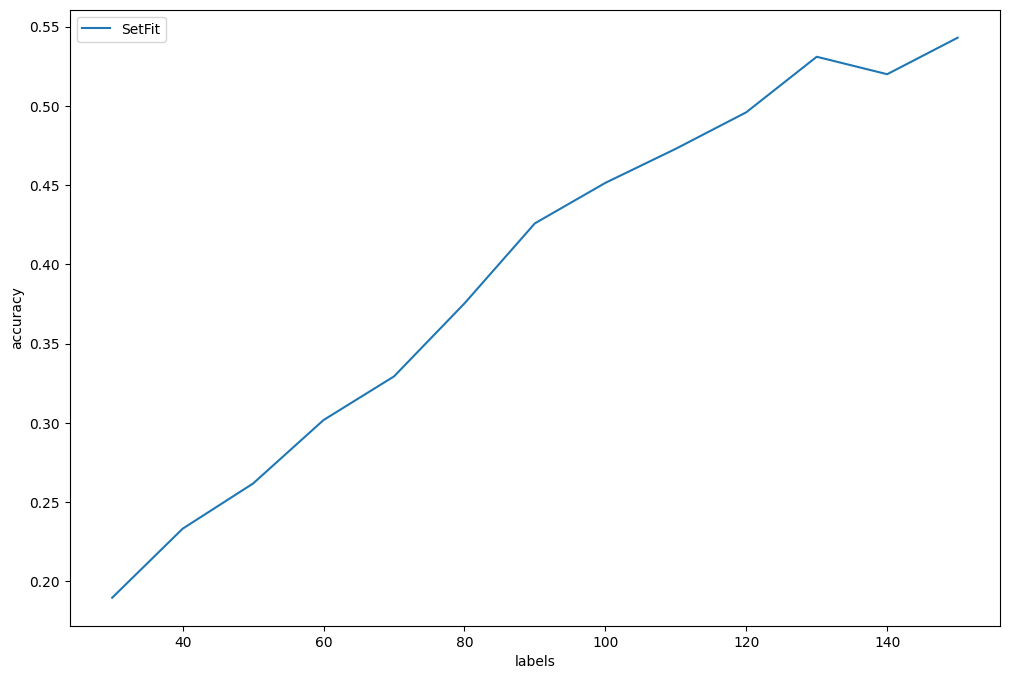

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.plot(label_list, accuracy_list, label='SetFit')
ax.legend()
plt.ylabel('accuracy')
plt.xlabel('labels')

display(plt)

In [18]:
from sklearn.metrics import confusion_matrix


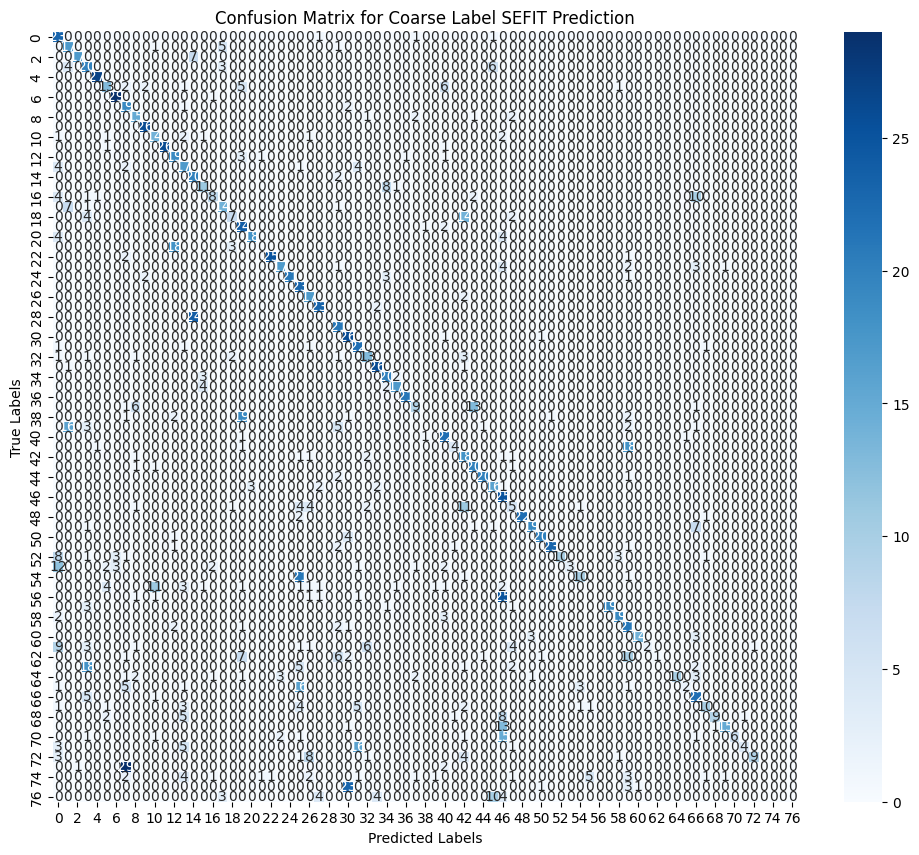

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['label'],y_pred_test)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Label SEFIT Prediction')
plt.show()

In [21]:
pd.DataFrame( {'actual': np.array(test_df['label']),'y_pred_test' : y_pred_test} ).to_csv('Sefit_Predictions.csv',index=False)
setfit_label_acc_df = pd.DataFrame({'Label' : label_list  ,"Accuracy":accuracy_list, 'Precision' : precision_list, 'Recall': recall_list })
setfit_label_acc_df.to_csv('setfit_label_acc.csv', index=False)